In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


In [22]:
def read_and_parse_label_file(path_to_label_file: str)-> pd.DataFrame:
    
    df = pd.read_csv(path_to_label_file, 
                 sep = '\x09',
                 header = 6,
                index_col = False
                )
    
    # cutting off header detail row and the last row
    trimmed_df = df[1:-1].copy()
    
    trim_cols = list(trimmed_df.columns)[1:] # excluding the #fields column name
    
    data = trimmed_df.iloc[:, :-1].copy() # excluding the last column
    
    # creating a dictionary to rename the columns
    rename_cols_dic = {}

    for old_col, new_col in zip(data.columns, trim_cols):
        rename_cols_dic[old_col] = new_col
        
    # renaming the columns
    data = data.rename(columns = rename_cols_dic).copy()
    
    
    # splitting this column into three new columns
    last_cols = data['tunnel_parents   label   detailed-label'].str.split('  ', expand = True)
    
    # renaming the newly split columns
    last_cols.rename(columns = {0:'tunnel_parents', 1:'label', 2: 'detailed-label'}, inplace = True)
    
    # merging the newly split columns onto the main df
    
    merge_df = data.merge(last_cols, left_index = True, right_index = True)
    
    # dropping the columns that was used to split into three
    
    final_df = merge_df.drop(columns = ['tunnel_parents   label   detailed-label']).copy()
    
    return final_df

example_data = "Malware_1.labeled"

final_df = read_and_parse_label_file(example_data)

final_df[:5]



/tmp/ipykernel_51446/2315226590.py:3: DtypeWarning: Columns (0,3,5,14,16,17,18,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_label_file,


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
1,1525879831.015811,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,tcp,-,2.999051,0,...,-,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
2,1525879831.025055,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,-,-,-,...,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
3,1525879831.045045,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,-,-,-,...,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
4,1525879832.016240,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,-,2.998796,0,...,-,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
5,1525879832.024985,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,-,-,-,...,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan


In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008748 entries, 1 to 1008748
Data columns (total 23 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ts              1008748 non-null  object
 1   uid             1008748 non-null  object
 2   id.orig_h       1008748 non-null  object
 3   id.orig_p       1008748 non-null  object
 4   id.resp_h       1008748 non-null  object
 5   id.resp_p       1008748 non-null  object
 6   proto           1008748 non-null  object
 7   service         1008748 non-null  object
 8   duration        1008748 non-null  object
 9   orig_bytes      1008748 non-null  object
 10  resp_bytes      1008748 non-null  object
 11  conn_state      1008748 non-null  object
 12  local_orig      1008748 non-null  object
 13  local_resp      1008748 non-null  object
 14  missed_bytes    1008748 non-null  object
 15  history         1008748 non-null  object
 16  orig_pkts       1008748 non-null  object
 17  orig_ip_

In [24]:
# Printing the column from the data frame
final_df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'label', 'detailed-label'],
      dtype='object')

In [25]:
# Returning all unique value from the missed bytes
final_df['missed_bytes'].unique()
final_df.missed_bytes

1            0
2            0
3            0
4            0
5            0
          ... 
1008744    0.0
1008745    0.0
1008746    0.0
1008747    0.0
1008748    0.0
Name: missed_bytes, Length: 1008748, dtype: object

In [26]:
columns_to_remove = ['ts', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'local_orig', 'local_resp', 'tunnel_parents', 'detailed-label']
columns_to_include = ['uid', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']

In [27]:
# Removing the column which is not useful and has insufficient data
columns_to_remove = ['ts', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'local_orig', 'local_resp', 'tunnel_parents', 'detailed-label']

# Specifing included column in data frame
label = LabelEncoder()
columns_to_include = []
for column in final_df.columns:
    
    if final_df[column].dtype == object:
        # Convert all values in the column to string to avoid mixed types issue
        final_df[column] = final_df[column].astype(str)
        final_df[column] = label.fit_transform(final_df[column])

    if column not in columns_to_remove:
        columns_to_include.append(column)

In [28]:
X = final_df[columns_to_include].drop('label', axis=1)
y = final_df['label']
X.head()

,uid,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
1,501604,16719,1,0,12941,1,1,6,0,22,26,615,0,0
2,280436,16719,1,0,0,0,0,6,0,22,1,949,0,0
3,53371,16719,1,0,0,0,0,6,0,22,1,949,0,0
4,223063,16719,1,0,12686,1,1,6,0,22,26,615,0,0
5,320278,16719,1,0,0,0,0,6,0,22,1,949,0,0


In [29]:

# Calling test_train_split on x and y to get new random instances of x_train, x_test, y_train, y_test
x_train,x_test,y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Defining the clf for random forest classifier
clf = RandomForestClassifier(random_state=0)

# fitting the model
clf.fit(x_train, y_train)

# Runing predictions
prediction = clf.predict(x_test)
score = accuracy_score(y_test, prediction)

# Printing the accuracy score of random forest classifier
print('Accuracy of Random Forest Classifier: {:.4f}'.format(score))

Accuracy of Random Forest Classifier: 0.9999


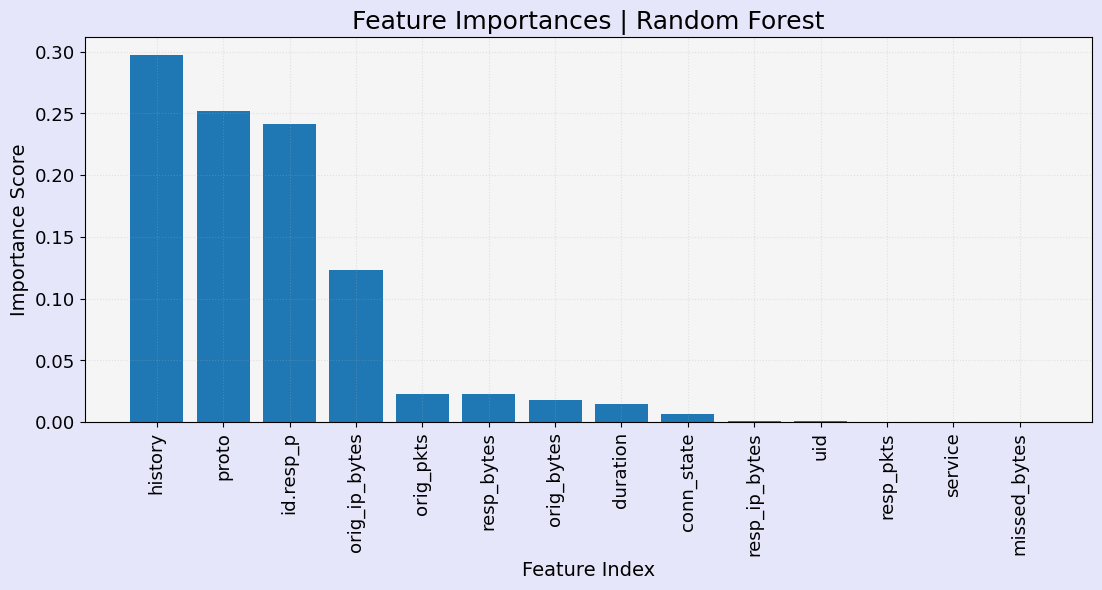

In [30]:
# Getting the feature importance scores from the trained Random Forest classifier
importances = clf.feature_importances_

# Sorting most importances in descending order
indices = np.argsort(importances)[::-1]

# Defining column name
cols = X.columns

# Reordering column name according to their features
ordered_cols_importance = [cols[X] for X in indices]

# Plotting a figure and axis object for the plot
fig, ax = plt.subplots(figsize=(13, 5))

# Plotting a bar chart for the feature importance
plt.title("Feature Importances | Random Forest", fontsize = 18)
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), ordered_cols_importance, rotation=90)

# Creating axis labels
plt.xlabel("Feature Index", fontsize = 14)
plt.ylabel("Importance Score", fontsize = 14)
ax.set_aspect('auto')

# Adding light gridlines for better readability
plt.grid(ls = ':', alpha = 0.3)

# Setting the background for better visibility
ax.set_aspect('auto')
fig.patch.set_facecolor('lavender')
ax.set_facecolor('whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=13)

# Saving the plot as a high resulution image
plt.savefig('random forest feature importance.jpeg', 
            dpi=1000,
            bbox_inches='tight'
           )

plt.show()

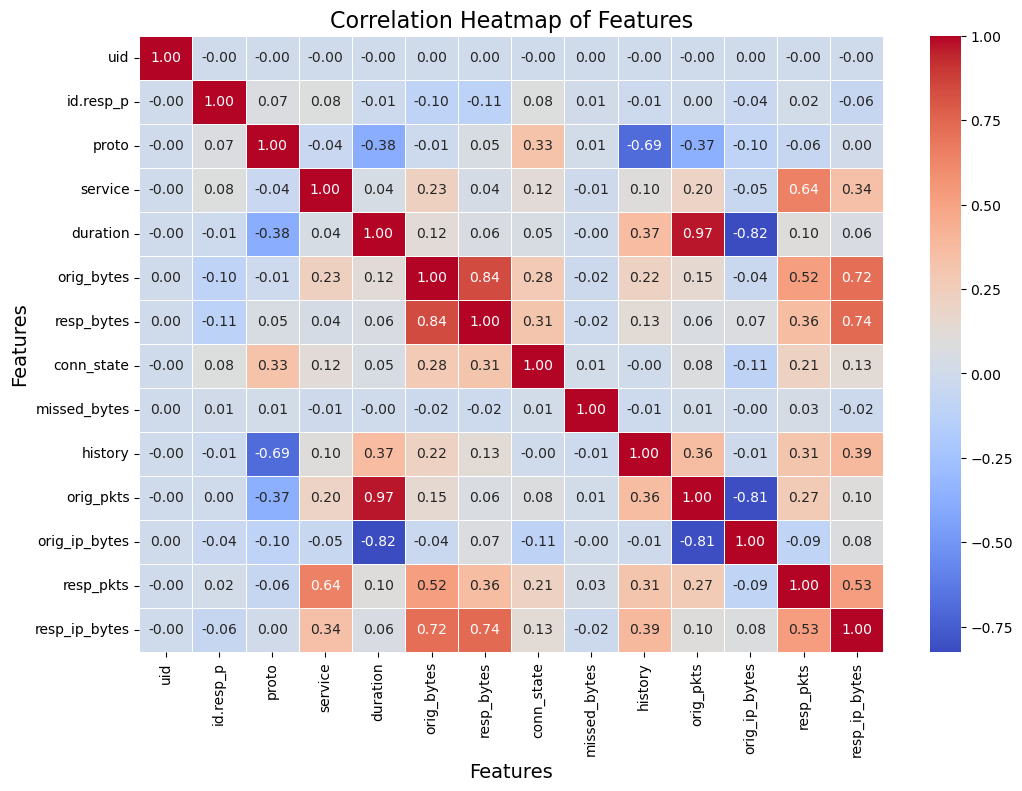

In [31]:
# Computing the correlation matrix for the features
correlation_matrix = X.corr()

# Plotting the heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Adding title and axis labels
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Displaying the plot
plt.show()